# Implementing $\pi_{\rm int} + \pi_{\rm OU}$ on the semi-circle
Simulation of agent following pheromone along a semi-circle connecting points A and B for a given distance/angle followed by exploration under OU policy. The agent lays pheromone on the way back if it succeeds in reaching Point B.
## TOC:
* [Single agent learning using epsilon-greedy policy](#first-bullet)

In [50]:
import numpy as np
import scipy as sp
import matplotlib as mpl
import matplotlib.pyplot as plt
import copy

import jax.numpy as jnp
import jax
from jax import random
from jax import jit
from jax import vmap
from jax import lax
from jax.tree_util import register_pytree_node
import time
import matplotlib.patheffects as path_effects

import importlib
import plotFns as pF
import prmts as pR

In [51]:
global colors
colors = {
    "gray": {
        0: "#f8f9fa",
        1: "#f1f3f5",
        2: "#e9ecef",
        3: "#dee2e6",
        4: "#ced4da",
        5: "#adb5bd",
        6: "#868e96",
        7: "#495057",
        8: "#343a40",
        9: "#212529",
    },
    "red": {
        0: "#fff5f5",
        1: "#ffe3e3",
        2: "#ffc9c9",
        3: "#ffa8a8",
        4: "#ff8787",
        5: "#ff6b6b",
        6: "#fa5252",
        7: "#f03e3e",
        8: "#e03131",
        9: "#c92a2a",
    },
    "pink": {
        0: "#fff0f6",
        1: "#ffdeeb",
        2: "#fcc2d7",
        3: "#faa2c1",
        4: "#f783ac",
        5: "#f06595",
        6: "#e64980",
        7: "#d6336c",
        8: "#c2255c",
        9: "#a61e4d",
    },
    "grape": {
        0: "#f8f0fc",
        1: "#f3d9fa",
        2: "#eebefa",
        3: "#e599f7",
        4: "#da77f2",
        5: "#cc5de8",
        6: "#be4bdb",
        7: "#ae3ec9",
        8: "#9c36b5",
        9: "#862e9c",
    },
    "violet": {
        0: "#f3f0ff",
        1: "#e5dbff",
        2: "#d0bfff",
        3: "#b197fc",
        4: "#9775fa",
        5: "#845ef7",
        6: "#7950f2",
        7: "#7048e8",
        8: "#6741d9",
        9: "#5f3dc4",
    },
    "indigo": {
        0: "#edf2ff",
        1: "#dbe4ff",
        2: "#bac8ff",
        3: "#91a7ff",
        4: "#748ffc",
        5: "#5c7cfa",
        6: "#4c6ef5",
        7: "#4263eb",
        8: "#3b5bdb",
        9: "#364fc7",
    },
    "blue": {
        0: "#e7f5ff",
        1: "#d0ebff",
        2: "#a5d8ff",
        3: "#74c0fc",
        4: "#4dabf7",
        5: "#339af0",
        6: "#228be6",
        7: "#1c7ed6",
        8: "#1971c2",
        9: "#1864ab",
    },
    "cyan": {
        0: "#e3fafc",
        1: "#c5f6fa",
        2: "#99e9f2",
        3: "#66d9e8",
        4: "#3bc9db",
        5: "#22b8cf",
        6: "#15aabf",
        7: "#1098ad",
        8: "#0c8599",
        9: "#0b7285",
    },
    "teal": {
        0: "#e6fcf5",
        1: "#c3fae8",
        2: "#96f2d7",
        3: "#63e6be",
        4: "#38d9a9",
        5: "#20c997",
        6: "#12b886",
        7: "#0ca678",
        8: "#099268",
        9: "#087f5b",
    },
    "green": {
        0: "#ebfbee",
        1: "#d3f9d8",
        2: "#b2f2bb",
        3: "#8ce99a",
        4: "#69db7c",
        5: "#51cf66",
        6: "#40c057",
        7: "#37b24d",
        8: "#2f9e44",
        9: "#2b8a3e",
    },
    "lime": {
        0: "#f4fce3",
        1: "#e9fac8",
        2: "#d8f5a2",
        3: "#c0eb75",
        4: "#a9e34b",
        5: "#94d82d",
        6: "#82c91e",
        7: "#74b816",
        8: "#66a80f",
        9: "#5c940d",
    },
    "yellow": {
        0: "#fff9db",
        1: "#fff3bf",
        2: "#ffec99",
        3: "#ffe066",
        4: "#ffd43b",
        5: "#fcc419",
        6: "#fab005",
        7: "#f59f00",
        8: "#f08c00",
        9: "#e67700",
    },
    "orange": {
        0: "#fff4e6",
        1: "#ffe8cc",
        2: "#ffd8a8",
        3: "#ffc078",
        4: "#ffa94d",
        5: "#ff922b",
        6: "#fd7e14",
        7: "#f76707",
        8: "#e8590c",
        9: "#d9480f",
    },
    "mixed": {
        0: "#880e4f",
        1: "#1a237e",
        2: "#e65100",
        3: "#004d40",
        4: "#c92a2a",
    },
}

 ## <a class="anchor" id="first-bullet">Single agent learning using epsilon-greedy policy</a>
 Agent updates its estimate of value function using $\epsilon$-greedy strategy

In [52]:
# Pheromone initial condition and class
p = pR.params()
xvec = np.linspace(-1.5*p.a, 1.5*p.a, p.nMsh)
xphm, yphm = np.meshgrid(xvec,
                         xvec)
cInit = np.zeros((p.nMsh, p.nMsh))
for ix in range(p.nMsh):
    for iy in range(p.nMsh):
        r = np.sqrt(xphm[ix][iy]**2+yphm[ix][iy]**2)
        if (r > (p.a-p.pt))  & (r < (p.a+p.pt)) & (yphm[ix][iy] >= 0):
            cInit[ix][iy] = 1.0
class phrmn():
    def __init__(self, cInit):
        super().__init__()
        self.c = cInit
        
# Interpolate value of pheromone to location r 
def phmChk(r, c):
    cVal = sp.interpolate.interp2d(xvec, xvec, c, kind='cubic')
    return cVal(r[0], r[1])
phm = phrmn(cInit)

In [53]:
# Agent class
class agent():
    global phm
    def __init__(self, ptr):
        super().__init__()
        p = copy.deepcopy(ptr)
        self.r = p.rInit #position of agent
        self.thet = p.thetInit #local orientation of agent
        self.rwd = 0.0 #reward collected
        self.sTrl = 0.0 #distance travelled by agent
        self.sInd = 0 #step count of agent
        self.valFn = np.zeros(p.nPtn) #value function initialized to zero
        self.phiSc = 0. #Angle at which bifurcation happens
        
    def intPolicy(self, ptr):
        p = copy.deepcopy(ptr)
        phi = np.arctan2(self.r[1], self.r[0])
        self.thet = phi + 0.5*np.pi + np.random.uniform(-np.pi/5, np.pi/5)
        self.r += p.l*np.array([np.cos(self.thet), np.sin(self.thet)])
        self.rwd += np.exp(-phi/p.phiSt)*p.l
        
        if np.linalg.norm(self.r) > (p.a+p.pt):
            self.thet = self.thet + np.pi*0.25
            self.r += p.l*np.array([np.cos(self.thet), np.sin(self.thet)])
            
        if np.linalg.norm(self.r) < (p.a-p.pt):
            self.thet = self.thet - np.pi*0.25
            self.r += p.l*np.array([np.cos(self.thet), np.sin(self.thet)])
    
    def ouPolicy(self, ptr):
        p = copy.deepcopy(ptr)
        self.r += p.l*np.array([np.cos(self.thet), np.sin(self.thet)])
        self.thet = self.thet*(1-p.nu*p.dt) + p.nu*p.dt*p.tgtPhi + np.sqrt(2*p.diff*p.dt)*np.random.normal()
        if np.linalg.norm(self.r - p.tgt) < p.sigma:
            self.rwd += (np.pi - np.arctan2(self.r[1], self.r[0]))*p.a
            self.sInd = p.nSteps
        if np.linalg.norm(self.r) > (p.a+p.pt+0.1):
            self.sInd = p.nSteps
        # self.valFn[iVal[0][-1]] = (self.valFn[iVal[0][-1]]+self.rwd)*0.5
        # self.thet = self.thet*(1-p.l) + p.l*p.tgtPhi + np.sqrt(2*p.pe*p.l)*np.random.normal()
    
    def reset(self, ptr):
        p = copy.deepcopy(ptr)
        self.r = p.rInit #position of agent
        self.thet = p.thetInit #local orientation of agent
        self.rwd = 0.0 #reward collected
        self.sTrl = 0.0 #distance travelled by agent
        self.sInd = 0 #step count of agent

--- 0.021604061126708984 seconds ---


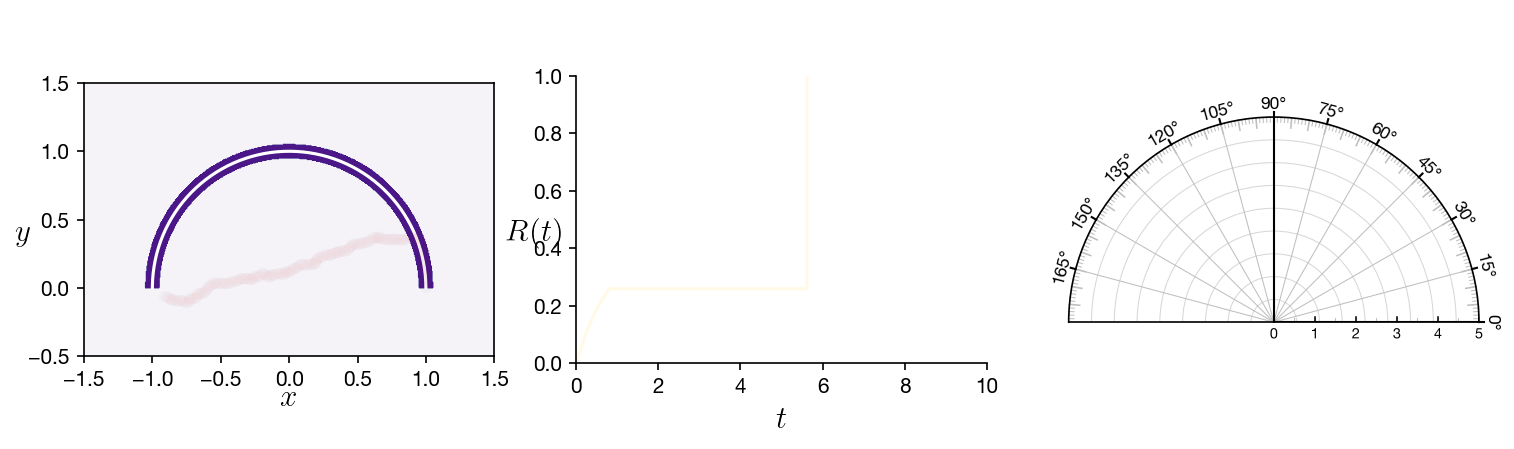

In [54]:
# Simple run
p = pR.params()
ag = agent(p)
start_time = time.time()
rxFull = np.array(p.rInit[0])
ryFull = np.array(p.rInit[1])
# thetFull = np.array(p.thetInit)
phxFull = np.array(np.cos(p.thetInit))
phyFull = np.array(np.sin(p.thetInit))
rwdFull = np.array(0.0)
while ag.sInd <= p.nSteps:
    if ag.sInd < p.nSc:
        ag.intPolicy(p)
    elif ag.sInd == p.nSc:
        tgtOrn = (p.tgt - ag.r)/np.linalg.norm(p.tgt - ag.r) #Orientation of the target from given location
        p.tgtPhi = np.arctan2(tgtOrn[1], tgtOrn[0])
        p.diff = p.diffCst/(np.pi - np.arctan2(ag.r[1],ag.r[0]))
        ag.ouPolicy(p)
    else:
        ag.ouPolicy(p)
    ag.sTrl += p.l
    ag.sInd += 1
    rxFull = np.vstack((rxFull, np.array(ag.r[0])))
    ryFull = np.vstack((ryFull, np.array(ag.r[1])))
    phxFull = np.vstack((phxFull, np.array(np.cos(ag.thet))))
    phyFull = np.vstack((phyFull, np.array(np.sin(ag.thet))))
    rwdFull = np.vstack((rwdFull, np.array(ag.rwd)))
print("--- %s seconds ---" % (time.time() - start_time))

import importlib
importlib.reload(pF)
fix, ax = pF.plotDef(5, p, xphm, yphm, phm)
pF.plotDat(fix, ax, p, rxFull, ryFull, phxFull, phyFull, rwdFull, ag.valFn)
plt.show()

/var/folders/by/4bp_bx4j7mqfwpptj2_7zwzw0000gn/T/ipykernel_14821/2098805913.py:38: RuntimeWarning: divide by zero encountered in scalar divide
  p.diff = p.diffCst/np.arctan2(ag.r[1],ag.r[0])
/var/folders/by/4bp_bx4j7mqfwpptj2_7zwzw0000gn/T/ipykernel_14821/2098805913.py:46: RuntimeWarning: invalid value encountered in cos
  phxFull = np.vstack((phxFull, np.array(np.cos(ag.thet))))
/var/folders/by/4bp_bx4j7mqfwpptj2_7zwzw0000gn/T/ipykernel_14821/2098805913.py:47: RuntimeWarning: invalid value encountered in sin
  phyFull = np.vstack((phyFull, np.array(np.sin(ag.thet))))
/var/folders/by/4bp_bx4j7mqfwpptj2_7zwzw0000gn/T/ipykernel_14821/2103325339.py:32: RuntimeWarning: invalid value encountered in cos
  self.r += p.l*np.array([np.cos(self.thet), np.sin(self.thet)])
/var/folders/by/4bp_bx4j7mqfwpptj2_7zwzw0000gn/T/ipykernel_14821/2103325339.py:32: RuntimeWarning: invalid value encountered in sin
  self.r += p.l*np.array([np.cos(self.thet), np.sin(self.thet)])
/var/folders/by/4bp_bx4j7mqfwp

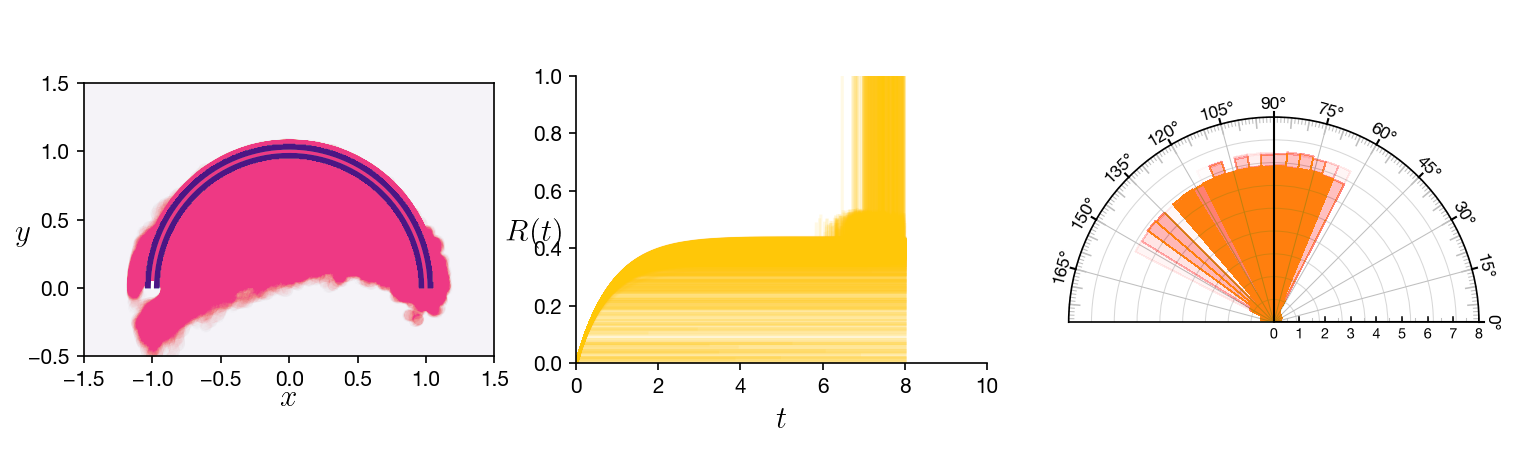

--- 136.49176907539368 seconds ---


In [59]:
importlib.reload(pF)
importlib.reload(pR)

phiPtn = np.linspace(0, np.pi, p.nPtn+1)
fix, ax = pF.plotDef(8, p, xphm, yphm, phm)

start_time = time.time()
ag = agent(p)

# for eInd in range(200):
for eInd in range(p.nEpchs):
    p = pR.params()
    rxFull = np.array(p.rInit[0])
    ryFull = np.array(p.rInit[1])
    phxFull = np.array(np.cos(p.thetInit))
    phyFull = np.array(np.sin(p.thetInit))
    rwdFull = np.array(0.0)
    if eInd < 1000:
        p.epsilon = 0.9
    else:
        p.epsilon = 0.1
    if (np.random.uniform() < p.epsilon) or (eInd < 100):
        p.nSc = np.random.uniform(0,np.pi)*(p.a-p.pt)//p.l
    else:
        iVmax = np.argmax(ag.valFn)
        p.nSc =  phiPtn[iVmax]//p.l
    # print(p.nSc)
    while ag.sInd <= p.nSteps:
        if ag.sInd < p.nSc:
            ag.intPolicy(p)
        elif ag.sInd == p.nSc:
            #Orientation of the target from given location
            tgtOrn = (p.tgt - ag.r)/np.linalg.norm(p.tgt - ag.r)
            p.tgtPhi = np.arctan2(tgtOrn[1], tgtOrn[0])
            #Diffusion as a function of \phi_c or equivalently s_c
            ag.phiSc = np.arctan2(ag.r[1], ag.r[0])
            # p.diff = p.diffCst/(np.pi - np.arctan2(ag.r[1],ag.r[0]))
            p.diff = p.diffCst/np.arctan2(ag.r[1],ag.r[0])
            ag.ouPolicy(p)
        else:
            ag.ouPolicy(p)
        ag.sTrl += p.l
        ag.sInd += 1
        rxFull = np.vstack((rxFull, np.array(ag.r[0])))
        ryFull = np.vstack((ryFull, np.array(ag.r[1])))
        phxFull = np.vstack((phxFull, np.array(np.cos(ag.thet))))
        phyFull = np.vstack((phyFull, np.array(np.sin(ag.thet))))
        rwdFull = np.vstack((rwdFull, np.array(ag.rwd)))
    iVal = np.where(phiPtn <= ag.phiSc)

    # ag.valFn[iVal[0][-1]] = (ag.valFn[iVal[0][-1]] + ag.rwd)*0.5
    ag.valFn[iVal[0][-1]] = ag.valFn[iVal[0][-1]]*(1 - p.alpha) + ag.rwd*p.alpha
    ag.reset(p)
    pF.plotDat(fix, ax, p, rxFull, ryFull, phxFull, phyFull, rwdFull, ag.valFn)
plt.show()
print("--- %s seconds ---" % (time.time() - start_time))


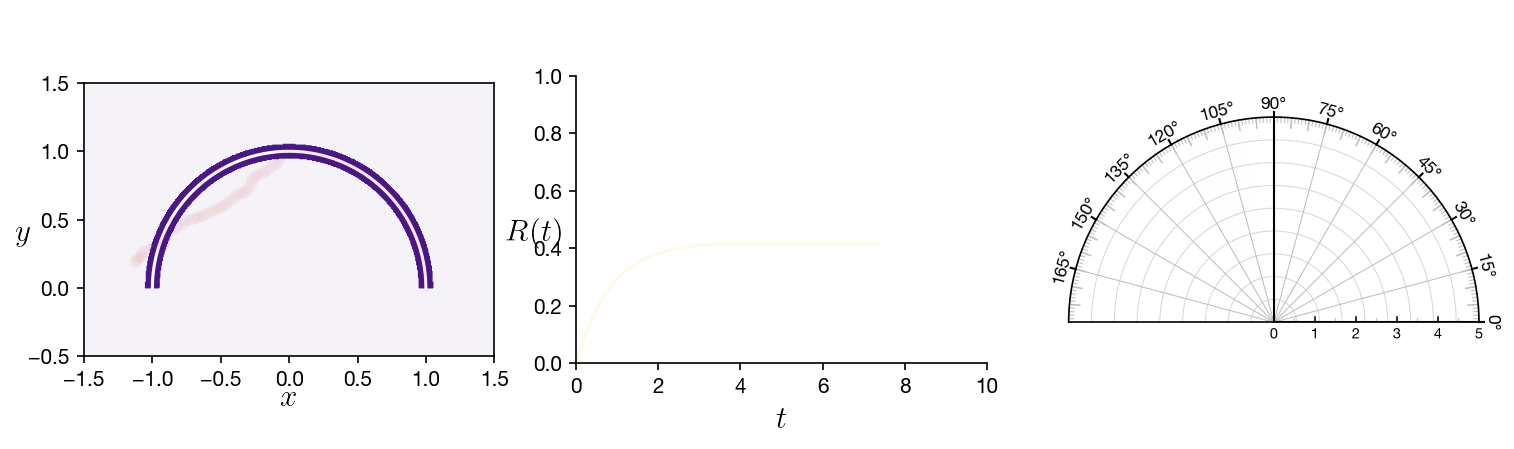

In [39]:
importlib.reload(pF)
fix, ax = pF.plotDef(5, p, xphm, yphm, phm)
pF.plotDat(fix, ax, p, rxFull, ryFull, phxFull, phyFull, rwdFull, ag.valFn)
plt.show()

Value function, $v(\phi)$ vs polar angle, $\phi$ at the last time-instant

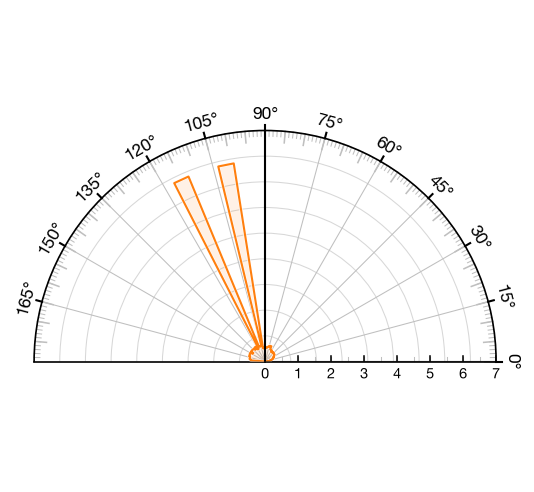

In [64]:
import importlib
importlib.reload(pF)
fig, ax = pF.plotRadial(7, p, ag.valFn)
plt.show()